In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skt

In [43]:
b1 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2014.json', orient='index')
b2 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2015.json', orient='index')
b4 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2017.json', orient='index')
b5 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2018.json', orient='index')
b6 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2019.json', orient='index')
b7 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2020.json', orient='index')
b8 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2021.json', orient='index')
b9 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2022.json', orient='index')
b10 = pd.read_json('C:\\Users\\diogo\\OneDrive\\Documentos\\Profissional\\Estatistica\\dados_brasileirao\\projeto_estatistica\\brasileirao-2023.json', orient='index')

In [44]:
def teste(br_df):
    #A estrutura fica no seguinte formato rodadas nas linhas e os confrontos nas colunas, normalizei para os confrontros, assim conseguimos expandir em colunas para melhores análises
    jogos = pd.concat([pd.json_normalize(br_df[0]),pd.json_normalize(br_df[1]),pd.json_normalize(br_df[2]),pd.json_normalize(br_df[3]),pd.json_normalize(br_df[4]), pd.json_normalize(br_df[5]), pd.json_normalize(br_df[6]), pd.json_normalize(br_df[7]), pd.json_normalize(br_df[8]), pd.json_normalize(br_df[9])], ignore_index=True)

    # %%
    #Transformando os gols de strings para valores numéricos

    jogos['goals.home'] = pd.to_numeric(jogos['goals.home'], downcast='integer')
    jogos['goals.away'] = pd.to_numeric(jogos['goals.away'], downcast='integer')

    # %%
    #Criando uma coluna de saldo de gols para poder atribuir vitória, derrota ou empate, além de ser um dos valores contidos na tabela final
    jogos['saldo_de_gols'] = jogos['goals.home'] - jogos['goals.away']

    # separando os valores de gols de cada clube, pois em uma linha está o time visitante e o de casa e mudando os nomes das colunas para o padrão esperado
    tabela_gols_casa = jogos[['clubs.home', 'goals.home', 'goals.away']]
    tabela_gols_visi =jogos[['clubs.away', 'goals.away', 'goals.home']]
    tabela_gols_casa.columns= [['clube', 'gm', 'gc']]
    tabela_gols_visi.columns= [['clube', 'gm', 'gc']]


    # Concatenando as duas tabelas e resetando o index
    tabela_gols = pd.concat([tabela_gols_casa, tabela_gols_visi]).reset_index(drop=True)


    # Retirando o multindex criado com a concatenação
    tabela_gols.columns = ['clube', 'gm', 'gc']

    # Agrupando as ocorrencias dos clubes somando os gols marcados e os gols contra
    tabela_gols = tabela_gols.groupby('clube')[['gm', 'gc']].sum()

    # Criando a Coluna Saldo de Gols que é um critério de desempate
    tabela_gols['sg']= tabela_gols['gm'] - tabela_gols['gc']

    # Criando uma coluna auxiliar para ter os pontos de cada rodada, colocando em uma lista seguindo a ordem para atribuir a cada time
    jogos['pontos'] = jogos['saldo_de_gols'].apply(
        lambda x: [1, 1] if x == 0 else ([3, 0] if x > 0 else [0, 3])
    )

    # Usando a mesma lógica para contabilizar as vitorias derrotas e empates
    jogos['vde'] = jogos['saldo_de_gols'].apply(
        lambda x: ['e', 'e'] if x == 0 else (['v', 'd'] if x > 0 else ['d', 'v'])
    )

    # populando uma tabela de visatantes e mandantes
    tabela_casa = []
    tabela_fora = []
    for i in range(len(jogos['pontos'])):
        tabela_casa.append([jogos['clubs.home'][i], jogos['pontos'][i][0], jogos['vde'][i][0]])
        tabela_fora.append([jogos['clubs.away'][i], jogos['pontos'][i][1], jogos['vde'][i][1]])




    # Transformando em um dataframe
    tabela_casa = pd.DataFrame(tabela_casa)
    tabela_fora = pd.DataFrame(tabela_fora)

    # Concatenando em uma tabela apenas, somando esses valores na tabela auxiliar que conta os pontos
    tabela = pd.concat([tabela_casa, tabela_fora])
    tabela2 =tabela.groupby(0)[1].sum()

    # %%
    tabela2 = pd.DataFrame(tabela2)

    # Trabalhando a mesma lógica para as vitorias, derrotas e empates que exigem tratamentos diferentes. 
    tabela3 = tabela.pivot_table(index= 0,columns=[1,2], aggfunc={2 :'value_counts'}).reset_index()
    tabela3.columns = ['clube', 'd', 'e', 'v']
    tabela3 = tabela3[['clube', 'v', 'd', 'e']]


    # Juntando as tabelas
    tabela_aux = tabela2.join(tabela_gols)

    # Nomeando as colunas
    tabela_aux.columns = ['pontos', 'gm', 'gc', 'sg']

    # Criando uma coluna para os clubes que viram indexes no processo de groupby
    tabela_aux['clube'] = tabela_aux.index

    # Agregando as tabelas usando a coluna clube como agregador
    tabela_final = tabela_aux.merge(tabela3, how = 'left', on= 'clube')

    # Ordenando as colunas de acordo com o resultado final que queremos
    tabela_final = tabela_final[['clube', 'pontos', 'v', 'e', 'd', 'gm', 'gc', 'sg']]

    # Ordenando de acordo com os critérios de desempate. 
    tabela_final =tabela_final.sort_values(by=['pontos', 'v', 'sg', 'gm'], axis=0, ascending=False).reset_index(drop=True)

    

    # Realizando o mesmo procedimento para os treinadores, foi feito a parte para algumas análises realizadas e não comentadas
    # Com essa tabela auxiliar dos treinadores, conseguimos ver o aproveitamento de cada treinador e que as trocas de treinadores aumenta o rendimento na maioria dos casos
    tt_casa = []
    tt_fora = []
    for i in range(len(jogos['pontos'])):
        tt_casa.append([jogos['clubs.home'][i], jogos['coach.home'][i], jogos['pontos'][i][0], jogos['vde'][i][0]])
        tt_fora.append([jogos['clubs.away'][i], jogos['coach.away'][i], jogos['pontos'][i][1], jogos['vde'][i][1]])



    # %%
    tt_casa = pd.DataFrame(tt_casa)
    tt_fora = pd.DataFrame(tt_fora)

    # Agregando os clubes e treinadores, escolhendo o sort False para mostrar na ordem que cada treinador aparece no campeonato, somando as colunas pontos e vde
    tabela_aux_treinadores = pd.concat([tt_casa,tt_fora])
    tabela_aux_treinadores_teste = tabela_aux_treinadores.groupby([0,1], sort=False)[[2,3]].sum()

    # Criando uma coluna auxiliar que passa na coluna vde, que está em uma string com todos os resultados dos treinadores, passando um len para contar o tamanho da string
    # e contar quantas rodadas esse treinador ficou
    tabela_aux_treinadores_teste['aux'] = tabela_aux_treinadores_teste[3].apply(lambda x : len(x))
    

    # Encontrando o treinador com o maior número de rodadas

    max_rodadas = tabela_aux_treinadores_teste.groupby(0)['aux'].max().reset_index()

    # Renomeando
    max_rodadas.columns = ['clube', 'rodadas']

    # agregando para sair na maneira que queremos
    tf = tabela_final.merge(max_rodadas, how='left', on= 'clube')
    return tf

In [45]:
br14 = teste(b1)
br15 = teste(b2)
br17 = teste(b4)
br18 = teste(b5)
br19 = teste(b6)
br20 = teste(b7)
br21 = teste(b8)
br22 = teste(b9)
br23 = teste(b10)


In [46]:
todos_br = [br14 , br15 , br18, br19 , br20, br21 , br22, br23]

In [47]:
for camp in todos_br:
    camp['posicao'] = range(1,len(camp.clube)+1)

In [48]:
br23

,clube,pontos,v,e,d,gm,gc,sg,rodadas,posicao
0,Palmeiras,70,20,10,8,64,33,31,32,1
1,Grêmio,68,21,5,12,63,56,7,37,2
2,Atlético-MG,66,19,9,10,52,32,20,26,3
3,Flamengo,66,19,9,10,56,42,14,24,4
4,Botafogo,64,18,10,10,58,37,21,11,5
5,Bragantino,62,17,11,10,49,35,14,38,6
6,Fluminense,56,16,8,14,51,47,4,33,7
7,Athletico-PR,56,14,14,10,51,43,8,28,8
8,Internacional,55,15,10,13,46,45,1,22,9
9,Fortaleza,54,15,9,14,45,44,1,38,10


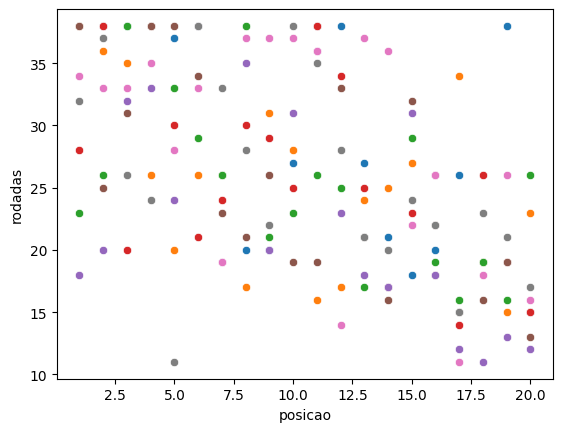

In [49]:
for camp in todos_br:
    sns.scatterplot(camp, x = camp.posicao, y = camp.rodadas)

In [50]:
for camp in todos_br:
    print(camp[['posicao', 'rodadas']].corr(method= 'pearson'))

          posicao   rodadas
posicao  1.000000 -0.598367
rodadas -0.598367  1.000000
          posicao   rodadas
posicao  1.000000 -0.514775
rodadas -0.514775  1.000000
          posicao   rodadas
posicao  1.000000 -0.610143
rodadas -0.610143  1.000000
         posicao  rodadas
posicao  1.00000 -0.54931
rodadas -0.54931  1.00000
          posicao   rodadas
posicao  1.000000 -0.521822
rodadas -0.521822  1.000000
          posicao   rodadas
posicao  1.000000 -0.690843
rodadas -0.690843  1.000000
          posicao   rodadas
posicao  1.000000 -0.542438
rodadas -0.542438  1.000000
          posicao   rodadas
posicao  1.000000 -0.478718
rodadas -0.478718  1.000000


In [51]:
camp_concat= pd.concat(todos_br)

In [52]:
from sklearn import linear_model

xt = camp_concat['posicao'].values.reshape(-1, 1)  # ou .values[:, np.newaxis]
yt = camp_concat['rodadas'].values
reg = linear_model.LinearRegression().fit(xt,yt)

In [53]:
print(reg.coef_)
print(reg.intercept_)
y_pred = reg.predict(xt)

[-0.76268797]
33.939473684210526


In [54]:
xt = xt.ravel()

Text(0.5, 1.0, 'Regressão Linear')

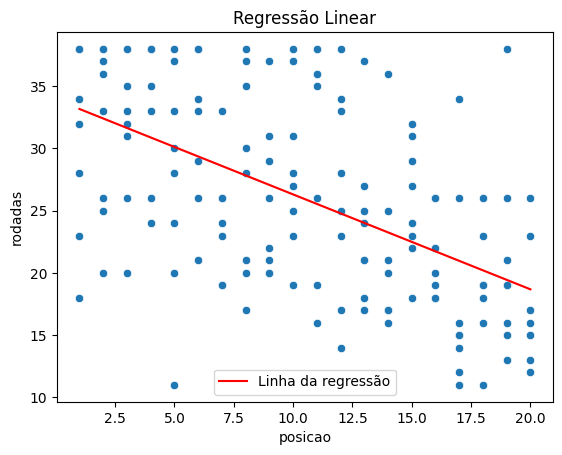

In [55]:
sns.scatterplot(camp_concat, x=camp_concat.posicao, y = camp_concat.rodadas)
sns.lineplot(x= xt, y =y_pred, color='red', label = 'Linha da regressão')
plt.title('Regressão Linear')